# Multi-Modal Detecting DeepFake Videos

- completed by:
    - Sanjay Dubey

overview of the dataset:

- Multi-Modal Detecting DeepFake Videos
- The dataset was collected by FaceForensics++ and Google Jigsaw as a means of advancing research on detecting deepfake videos. The dataset was released in 2019 and includes over 5,000 deepfake videos and real videos, along with corresponding metadata files. Here, we have downloaded 4.9 GB data that contain 400 videos. It has 322 Fake category and 77 real category.The label column in the metadata.json file indicates whether the video is REAL or FAKE. 
- To report the results  accuracy as a metric will be used. Additionally, the DeepFake competition suggests reporting the Area Under the Receiver Operating Characteristic Curve (AUC-ROC) as a performance metric has been suggested by the Kaggle competition. In combination with above, for individual models based F1 recall is used while mcnemar test is used to evaluate each model on the dataset. 

To detect DeepFakes we will need to use both video and audio data:

1. Frames from the videos is extracted and preprocessed for use as input. Libraries such as OpenCV or PyTorch can be used to extract frames from the videos. Once the frames is extracted, we can preprocess them using techniques such as normalization or resizing to prepare them for input to a deep learning model.

2. To featurize the audio data, MFCCs (Mel Frequency Cepstral Coefficients) method is used as suggested librosa library in Python was used to calculate the MFCCs for each audio clip. Once the MFCCs is calculated, normalization or standardization was applied.

After the video and audio data featurization, we can combine them and use them as input to a multimodal. 


In [1]:
import json
import os
import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as t_F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset
import cv2
import librosa
from PIL import Image

In [2]:
def face_detect(frame):
    
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize frame of video to 1/4 size for faster face detection processing
    small_frame = cv2.resize(gray, (0, 0), fx=0.25, fy=0.25)
    # Detect the faces
    faces = face_cascade.detectMultiScale(small_frame, 1.1, 4)
    return faces


def readVideo(videoFile, num_mfcc=13, n_fft=4096, hop_length=1024 ):

    max_attempts = 60
    # Open the video file
    cap = cv2.VideoCapture(videoFile)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    #cap.set(1, self.frame_no)
    # nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # frames = torch.FloatTensor(self.channels, self.timeDepth, self.xSize, self.ySize)
    #frames=[]
    attempts = 0
    while attempts < max_attempts:
        ret, frame = cap.read()
        
        
        # Get audio properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # Extract audio frames
        #audio_frames = []
        
        attempts += 1
        if ret:
            last_good_frame = frame
            
            #gray1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            #audio_frames.append(gray1)
            # Load audio frames and extract MFCCs
            y1, sr = librosa.load(videoFile, sr=16000)
            mfccs = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=40)
            
            #y1 = np.array(audio_frames, dtype=np.float32)
            #mfccs = librosa.feature.mfcc(y=y1, sr=fps, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            # Normalize MFCCs
            normalized_mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)
            tensor_mfccs = torch.from_numpy(normalized_mfccs.T).float()
            try:
                faces = face_detect(frame)
                
                
                
                
                # Face detected
                if len(faces) > 0:
                    # Get the face, if more than two, use the whole frame
                    if len(faces) > 1:
                        break
                    x, y, w, h = faces[0] * 4
                    x -= 40
                    y -= 40
                    w += 80
                    h += 80
                    face_img = frame[y: y + h, x: x + w]
                    frame = torch.from_numpy(face_img)
                    # HWC2CHW
                    frame = frame.permute(2, 0, 1)
                    frame = t_F.to_pil_image(frame)
                    frame = transform(frame)
                    cap.release()
                    return frame, tensor_mfccs
            except:
                continue
        else:
            break

    frame = torch.from_numpy(last_good_frame)
    
    
    
    # HWC2CHW
    frame = frame.permute(2, 0, 1)
    frame = t_F.to_pil_image(frame)
    frame = transform(frame)
    cap.release()
    return frame, tensor_mfccs



There are two modalities in the DeepFake Detection Chalenge dataset - video and audio. 
- video modality includes frames of video data in .mp4 format that can be used as input features for a machine learning model. 
- audio modality includes preprocessed Mel Frequency Cepstral Coefficients (MFCCs) that can also be used as input features.
- The classification task involves detecting deepfake videos by combining information from both modalities and explore general to check effectiveness of using both modlity. This is a multimodal task that involves using both video and audio data. As both modalit can be extracted and represented using tensor or array, they belong to same domain. However, the types of features extracted from each modality are different. For the video modality, features such as color histograms, optical flow, and deep neural network features can be extracted from the video frames. For the audio modality, features such as MFCCs, spectral contrast, and spectral bandwidth can be extracted from the preprocessed audio data. Combination of information from both modality is expected to provide better performance in detecting deepfake.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Reads in video files from a specified directory, 
#extracts both video and audio features
#along with the corresponding label (either "FAKE" or "REAL") obtained from the metadata file.

video_dir = "/users/skdubey/data/train_sample_videos"

# read metadata file
with open("/users/skdubey/data/train_sample_videos/metadata.json", "r") as f:
    metadata = json.load(f)
df={}
for video_file in tqdm.tqdm(os.listdir(video_dir)):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(video_dir, video_file)

        # if video_id is present in metadata
        if video_file in metadata:
            label = metadata[video_file]["label"]

            # read video and preprocess
            video_tensor, audio_tensor = readVideo(video_path)
            df[video_file]={}
            if label=='FAKE':
                df[video_file]['target'] = 0
            elif label=='REAL':
                df[video_file]['target'] = 1
            df[video_file]['label']=label
            df[video_file]['audio_data']=audio_tensor
            df[video_file]['video_data']=video_tensor
            
            

        else:
            print(f"No label found for {video_file}")
    
print("Processed all audio and video files successfully")


100%|██████████| 400/400 [37:53<00:00,  5.68s/it]  

Processed all audio and video files successfully


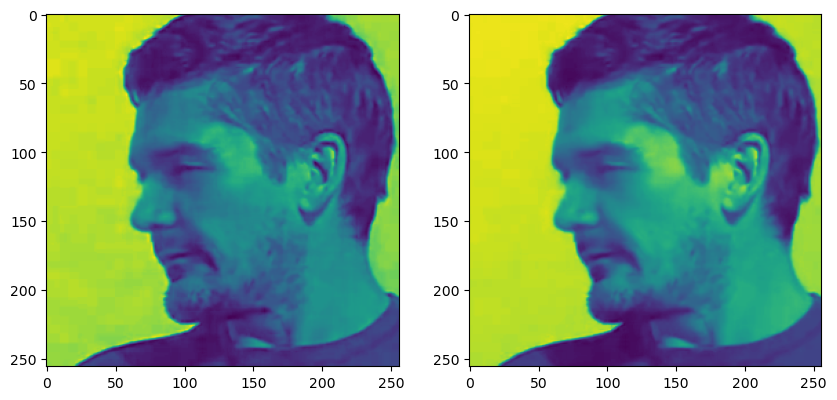

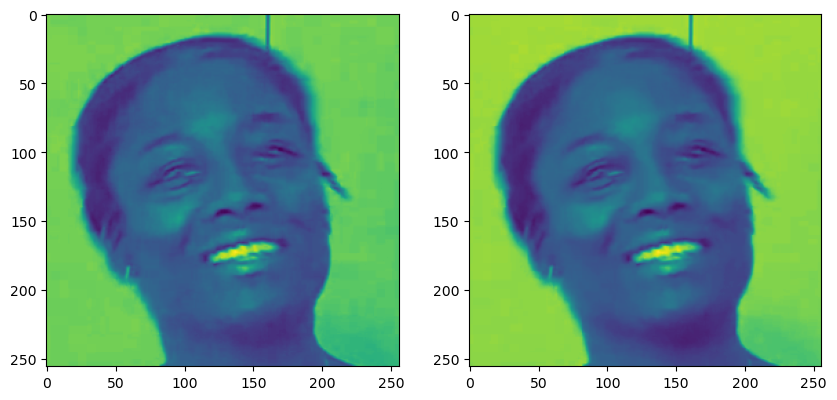

In [21]:
import matplotlib.pyplot as plt
video_files = list(df.keys())[:2]
for video_file in video_files:
    video_data = df[video_file]['video_data']
    video_frames = video_data[:2]
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(video_frames[0])
    axs[1].imshow(video_frames[1])
    plt.show() 

Each sample contains two inputs which is stroed in df dictionary, here we provide overview of df dictionary:
- audio_data and video_data, and a label for the target FAKE or REAL. 
- audio_data tensor has a shape of (313, 40), which means there are 313 frames of audio data, and each frame has 40 features. 
- video_data tensor has a shape of (3, 256, 256), which means there are 3 RGB frames of video data, each of size 256x256 pixels.
- The target label is represented as a number, where 0 corresponds to FAKE and 1 corresponds to REAL.

In [7]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 64 * 64)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

class VideoDataset(Dataset):
    def __init__(self, df):
        self.keys = list(df.keys())
        self.values = list(df.values())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        video_data = self.values[index]["video_data"]
        label = self.values[index]["target"]
        return video_data, label





The CNN architecture consists of two convolutional layers, each followed by a ReLU activation function and a max pooling layer. These are then followed by two fully connected (linear) layers and ReLU activation function, and the final output layer which gives the binary classification output. The VideoDataset class defines how the data is loaded from the dataset, and is used by the DataLoader objects. 

df dict data:
key: video file names
audio_data: torch.Size([313, 40])
video_data: torch.Size([3, 256, 256])
target as number 0 for FAKE and 1 for REAL
label: FAKE and REAL

In [8]:
model = SimpleCNN()
#dataset = VideoDataset(df)

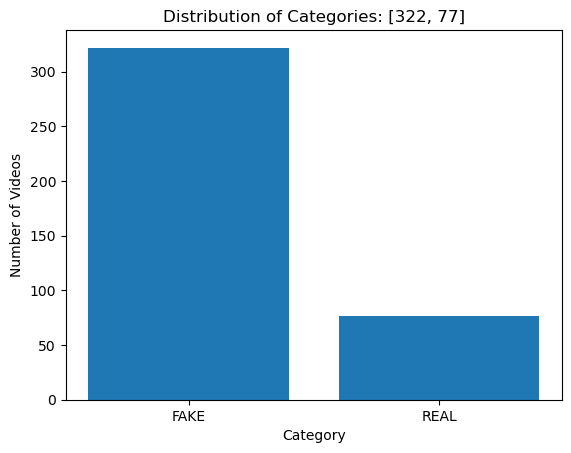

In [22]:
#distribution
counts = [0, 0]
for video_file in df.keys():
    label = df[video_file]['label']
    if label == 'FAKE':
        counts[0] += 1
    elif label == 'REAL':
        counts[1] += 1

#histogram
categories = ['FAKE', 'REAL']
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.title(f'Distribution of Categories: {counts}')
plt.show()


We preferred using StratifiedKfold from sklearn for splitting the data as there are few number of REAL video that create imbalance in dataset. It is expected to stratify similar representation of across all the fold. It also uses the StratifiedKFold class from scikit-learn to create the k-fold cross-validator. For each fold, we creates VideoDataset and DataLoader objects for the training, validation sets and trains the model on the current fold for the specified number of epochs. In each epoch, forward pass, backward pass is performed and optimizer is updated.

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

Fold [1/3]
Epoch [1/10], Train Loss: 0.4525, Train Accuracy: 81.58%, Val Loss: 0.5225, Val Accuracy: 75.19%, Val F1: 0.7153, Val AUC: 0.4937
Epoch [2/10], Train Loss: 0.3500, Train Accuracy: 88.72%, Val Loss: 0.5882, Val Accuracy: 81.20%, Val F1: 0.7410, Val AUC: 0.5154
Epoch [3/10], Train Loss: 0.3006, Train Accuracy: 88.35%, Val Loss: 0.7233, Val Accuracy: 80.45%, Val F1: 0.7367, Val AUC: 0.5107
Epoch [4/10], Train Loss: 0.2278, Train Accuracy: 92.11%, Val Loss: 0.6506, Val Accuracy: 75.19%, Val F1: 0.7296, Val AUC: 0.5244
Epoch [5/10], Train Loss: 0.1858, Train Accuracy: 93.98%, Val Loss: 0.8577, Val Accuracy: 81.95%, Val F1: 0.7670, Val AUC: 0.5507
Epoch [6/10], Train Loss: 0.1783, Train Accuracy: 93.61%, Val Loss: 1.2958, Val Accuracy: 75.94%, Val F1: 0.7010, Val AUC: 0.4676
Epoch [7/10], Train Loss: 0.1501, Train Accuracy: 95.11%, Val Loss: 0.9439, Val Accuracy: 73.68%, Val F1: 0.7196, Val AUC: 0.5152
Epoch [8/10], Train Loss: 0.1024, Train Accuracy: 97.37%, Val Loss: 1.1528, Val

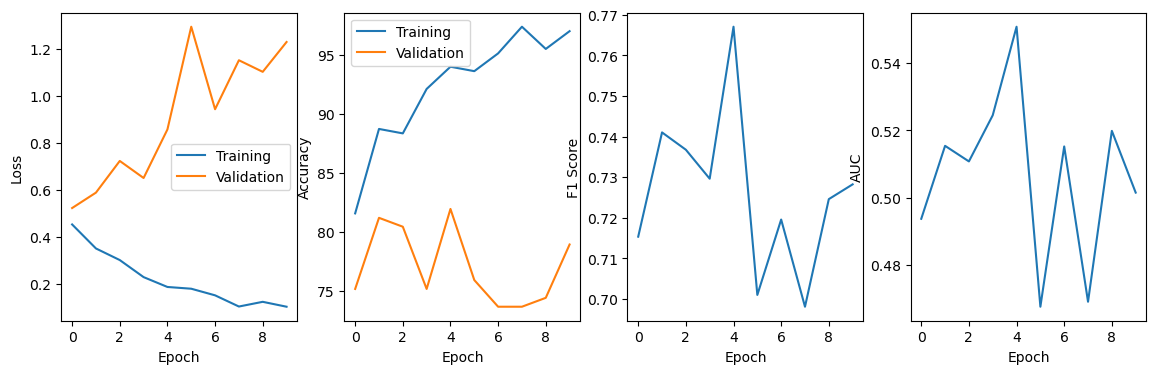

Fold [2/3]
Epoch [1/10], Train Loss: 0.4924, Train Accuracy: 87.22%, Val Loss: 0.2108, Val Accuracy: 96.99%, Val F1: 0.9699, Val AUC: 0.9522
Epoch [2/10], Train Loss: 0.3045, Train Accuracy: 90.98%, Val Loss: 0.2064, Val Accuracy: 92.48%, Val F1: 0.9193, Val AUC: 0.8223
Epoch [3/10], Train Loss: 0.2017, Train Accuracy: 93.23%, Val Loss: 0.1530, Val Accuracy: 93.23%, Val F1: 0.9295, Val AUC: 0.8560
Epoch [4/10], Train Loss: 0.1241, Train Accuracy: 95.49%, Val Loss: 0.3405, Val Accuracy: 87.97%, Val F1: 0.8874, Val AUC: 0.8961
Epoch [5/10], Train Loss: 0.1082, Train Accuracy: 97.37%, Val Loss: 0.2701, Val Accuracy: 93.98%, Val F1: 0.9379, Val AUC: 0.8753
Epoch [6/10], Train Loss: 0.0777, Train Accuracy: 96.99%, Val Loss: 0.4216, Val Accuracy: 89.47%, Val F1: 0.8846, Val AUC: 0.7599
Epoch [7/10], Train Loss: 0.0612, Train Accuracy: 98.87%, Val Loss: 0.3099, Val Accuracy: 92.48%, Val F1: 0.9209, Val AUC: 0.8368
Epoch [8/10], Train Loss: 0.0613, Train Accuracy: 98.50%, Val Loss: 0.3677, Val

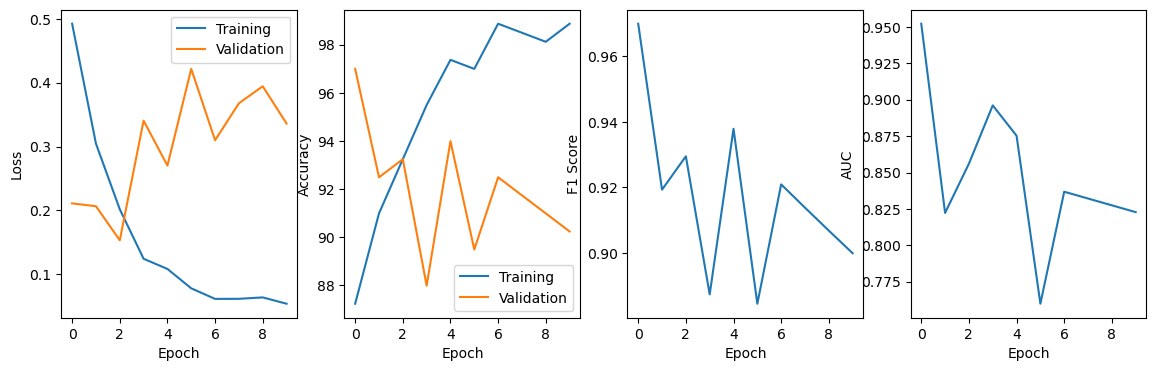

Fold [3/3]
Epoch [1/10], Train Loss: 0.2050, Train Accuracy: 93.98%, Val Loss: 0.0487, Val Accuracy: 99.25%, Val F1: 0.9924, Val AUC: 0.9808
Epoch [2/10], Train Loss: 0.1251, Train Accuracy: 96.62%, Val Loss: 0.0764, Val Accuracy: 96.24%, Val F1: 0.9621, Val AUC: 0.9330
Epoch [3/10], Train Loss: 0.1227, Train Accuracy: 95.11%, Val Loss: 0.0774, Val Accuracy: 96.99%, Val F1: 0.9695, Val AUC: 0.9376
Epoch [4/10], Train Loss: 0.0790, Train Accuracy: 97.37%, Val Loss: 0.0738, Val Accuracy: 97.74%, Val F1: 0.9773, Val AUC: 0.9569
Epoch [5/10], Train Loss: 0.0692, Train Accuracy: 97.74%, Val Loss: 0.0877, Val Accuracy: 98.50%, Val F1: 0.9850, Val AUC: 0.9761
Epoch [6/10], Train Loss: 0.0600, Train Accuracy: 96.62%, Val Loss: 0.0984, Val Accuracy: 97.74%, Val F1: 0.9773, Val AUC: 0.9569
Epoch [7/10], Train Loss: 0.0825, Train Accuracy: 96.99%, Val Loss: 0.1042, Val Accuracy: 96.99%, Val F1: 0.9703, Val AUC: 0.9668
Epoch [8/10], Train Loss: 0.0703, Train Accuracy: 98.12%, Val Loss: 0.0804, Val

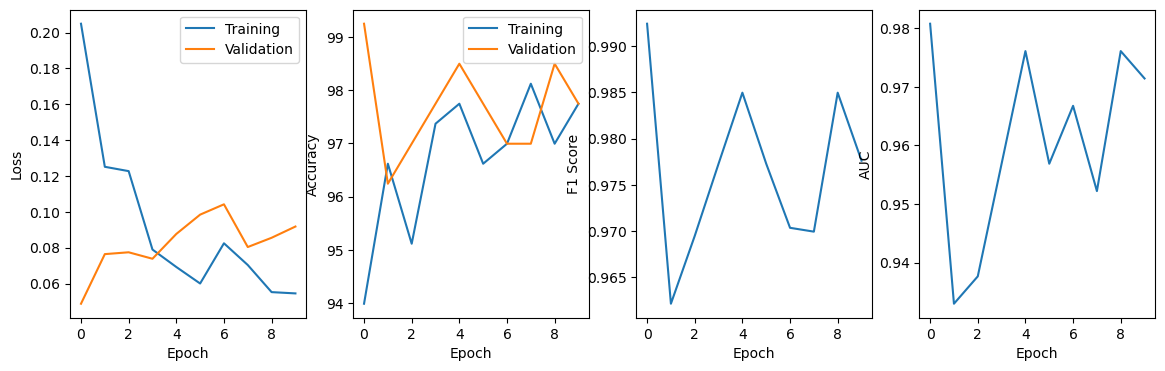

In [13]:
num_folds = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

#k-fold cross-validator
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


for fold, (train_idx, val_idx) in enumerate(skf.split(list(df.keys()), [v["target"] for v in df.values()])):
    print(f"Fold [{fold+1}/{num_folds}]")
    train_loss_list = []
    val_loss_list = []
    train_acc_list=[]
    val_acc_list=[]
    train_f1_list=[]
    val_f1_list=[]
    train_auc_list=[]
    val_auc_list=[]
    #VideoDataset and DataLoader objects
    train_dataset = VideoDataset({k: v for i, (k, v) in enumerate(df.items()) if i in train_idx})
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # validation set
    val_dataset = VideoDataset({k: v for i, (k, v) in enumerate(df.items()) if i in val_idx})
    val_loader = DataLoader(val_dataset, batch_size=32)

    # current fold
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_total = 0
        train_correct = 0
        train_predictions = []
        train_targets = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the training loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
        train_loss = train_loss / train_total
        train_acc = 100.0 * train_correct / train_total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        train_f1 = f1_score(train_targets, train_predictions, average='macro')
        train_f1_list.append(train_f1)
        fpr, tpr, thresholds = roc_curve(train_targets, train_predictions, pos_label=1)
        train_auc = auc(fpr, tpr)
        train_auc_list.append(train_auc)
        model.eval()
        val_loss = 0
        val_total = 0
        val_correct = 0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Update the validation loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        val_loss = val_loss / val_total
        val_acc = 100.0 * val_correct / val_total
            # Compute F1 score and AUC
        val_f1 = f1_score(val_targets, val_predictions, average='weighted')
        val_auc = roc_auc_score(val_targets, val_predictions, average='weighted', multi_class='ovr')

        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        val_f1_list.append(val_f1)
        val_auc_list.append(val_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")


    # Plot for training and validation
    plt.figure(figsize=(14,4))
    plt.subplot(1,4,1)
    plt.plot(train_loss_list, label='Training')
    plt.plot(val_loss_list, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,4,2)
    plt.plot(train_acc_list, label='Training')
    plt.plot(val_acc_list, label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,4,3)
    plt.plot(val_f1_list)
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')

    plt.subplot(1,4,4)
    plt.plot(val_auc_list)
    plt.ylabel('AUC')
    plt.xlabel('Epoch')

    plt.show()


- audio model using simple rnn

In [24]:
class AudioDataset(Dataset):
    def __init__(self, df):
        self.keys = list(df.keys())
        self.values = list(df.values())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        audio_data = self.values[index]["audio_data"]
        label = self.values[index]["target"]
        return audio_data, label


In [28]:
# Create model, loss function, and optimizer
#an instance of the SimpleRNN model with input size of 40,
#hidden size of 128, 3 layers, and output size of 2. 
#This model will take in input of size (batch_size, sequence_length, input_size) 
#and output a tensor of size (batch_size, output_size).

In [25]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        #hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        #Forward propagate
        out, _ = self.rnn(x, h0)
        
        #Decode the last time step
        out = self.fc(out[:, -1, :])
        return out


In [55]:
#model, loss function, and optimizer
model = SimpleRNN(input_size=40, hidden_size=64, num_layers=2, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Train
num_epochs = 10
for epoch in range(num_epochs):
    for i, (audio_data, target) in enumerate(audio_train_loader):
        # Forward pass
        outputs = model(audio_data)
        loss = criterion(outputs, target)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(audio_train_loader)}], Loss: {loss.item():.4f}")

#Evaluate the validation
with torch.no_grad():
    correct = 0
    total = 0
    for audio_data, target in audio_val_loader:
        outputs = model(audio_data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f"Accuracy on validation set: {(100 * correct / total):.2f}%")


Epoch [1/10], Step [10/10], Loss: 0.4404
Epoch [2/10], Step [10/10], Loss: 0.5336
Epoch [3/10], Step [10/10], Loss: 0.4968
Epoch [4/10], Step [10/10], Loss: 0.4309
Epoch [5/10], Step [10/10], Loss: 0.5508
Epoch [6/10], Step [10/10], Loss: 0.4849
Epoch [7/10], Step [10/10], Loss: 0.5129
Epoch [8/10], Step [10/10], Loss: 0.3351
Epoch [9/10], Step [10/10], Loss: 0.4173
Epoch [10/10], Step [10/10], Loss: 0.3017
Accuracy on validation set: 75.00%


The SimpleRNN class is a custom RNN-based neural network. It takes in the input size, hidden size, number of layers, and output size as arguments and constructs an RNN layer and a fully connected layer. The forward method takes in the input data x, initializes the hidden state with zeros, forward propagates the RNN layer, and returns the output of the fully connected layer after decoding the hidden state of the last time step.

Fold [1/3]
Epoch [1/10], Train Loss: 1.7831, Train Accuracy: 68.42%, Val Loss: 0.4768, Val Accuracy: 81.20%
Epoch [2/10], Train Loss: 0.5000, Train Accuracy: 80.45%, Val Loss: 0.4799, Val Accuracy: 81.20%
Epoch [3/10], Train Loss: 0.4725, Train Accuracy: 80.45%, Val Loss: 0.6120, Val Accuracy: 81.20%
Epoch [4/10], Train Loss: 0.4904, Train Accuracy: 80.45%, Val Loss: 0.4936, Val Accuracy: 81.20%
Epoch [5/10], Train Loss: 0.4413, Train Accuracy: 80.45%, Val Loss: 0.5169, Val Accuracy: 79.70%
Epoch [6/10], Train Loss: 0.4202, Train Accuracy: 81.58%, Val Loss: 0.6999, Val Accuracy: 81.20%
Epoch [7/10], Train Loss: 0.4316, Train Accuracy: 82.71%, Val Loss: 0.5189, Val Accuracy: 80.45%
Epoch [8/10], Train Loss: 0.4178, Train Accuracy: 83.46%, Val Loss: 0.5560, Val Accuracy: 74.44%
Epoch [9/10], Train Loss: 0.3803, Train Accuracy: 85.34%, Val Loss: 0.5455, Val Accuracy: 80.45%
Epoch [10/10], Train Loss: 0.3422, Train Accuracy: 87.59%, Val Loss: 0.5646, Val Accuracy: 79.70%


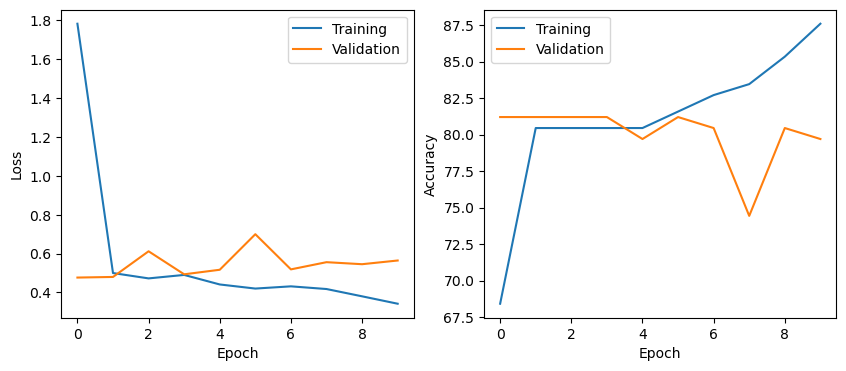

Fold [2/3]
Epoch [1/10], Train Loss: 0.4587, Train Accuracy: 84.21%, Val Loss: 0.3173, Val Accuracy: 90.23%
Epoch [2/10], Train Loss: 0.4210, Train Accuracy: 83.46%, Val Loss: 0.3350, Val Accuracy: 86.47%
Epoch [3/10], Train Loss: 0.3742, Train Accuracy: 84.59%, Val Loss: 0.3411, Val Accuracy: 89.47%
Epoch [4/10], Train Loss: 0.3276, Train Accuracy: 86.09%, Val Loss: 0.3528, Val Accuracy: 87.22%
Epoch [5/10], Train Loss: 0.2728, Train Accuracy: 87.22%, Val Loss: 0.3622, Val Accuracy: 87.97%
Epoch [6/10], Train Loss: 0.2122, Train Accuracy: 92.86%, Val Loss: 0.3822, Val Accuracy: 86.47%
Epoch [7/10], Train Loss: 0.1737, Train Accuracy: 93.98%, Val Loss: 0.4364, Val Accuracy: 84.96%
Epoch [8/10], Train Loss: 0.1658, Train Accuracy: 93.61%, Val Loss: 0.4763, Val Accuracy: 84.96%
Epoch [9/10], Train Loss: 0.1510, Train Accuracy: 94.74%, Val Loss: 0.4843, Val Accuracy: 81.20%
Epoch [10/10], Train Loss: 0.1652, Train Accuracy: 93.98%, Val Loss: 0.5678, Val Accuracy: 83.46%


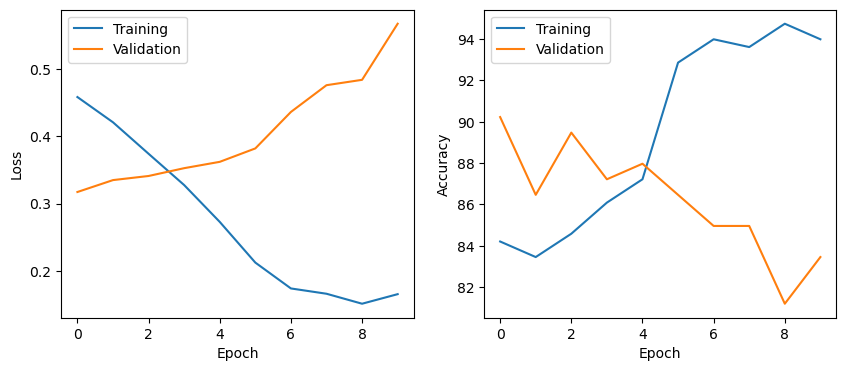

Fold [3/3]
Epoch [1/10], Train Loss: 0.3217, Train Accuracy: 88.72%, Val Loss: 0.1539, Val Accuracy: 96.99%
Epoch [2/10], Train Loss: 0.2466, Train Accuracy: 91.73%, Val Loss: 0.1880, Val Accuracy: 92.48%
Epoch [3/10], Train Loss: 0.2156, Train Accuracy: 90.60%, Val Loss: 0.1840, Val Accuracy: 96.24%
Epoch [4/10], Train Loss: 0.1487, Train Accuracy: 94.74%, Val Loss: 0.1595, Val Accuracy: 94.74%
Epoch [5/10], Train Loss: 0.1176, Train Accuracy: 96.62%, Val Loss: 0.1605, Val Accuracy: 94.74%
Epoch [6/10], Train Loss: 0.1148, Train Accuracy: 96.24%, Val Loss: 0.1614, Val Accuracy: 95.49%
Epoch [7/10], Train Loss: 0.0944, Train Accuracy: 96.99%, Val Loss: 0.1713, Val Accuracy: 93.98%
Epoch [8/10], Train Loss: 0.0938, Train Accuracy: 96.99%, Val Loss: 0.1673, Val Accuracy: 93.98%
Epoch [9/10], Train Loss: 0.0846, Train Accuracy: 96.99%, Val Loss: 0.1609, Val Accuracy: 94.74%
Epoch [10/10], Train Loss: 0.0644, Train Accuracy: 98.12%, Val Loss: 0.1711, Val Accuracy: 92.48%


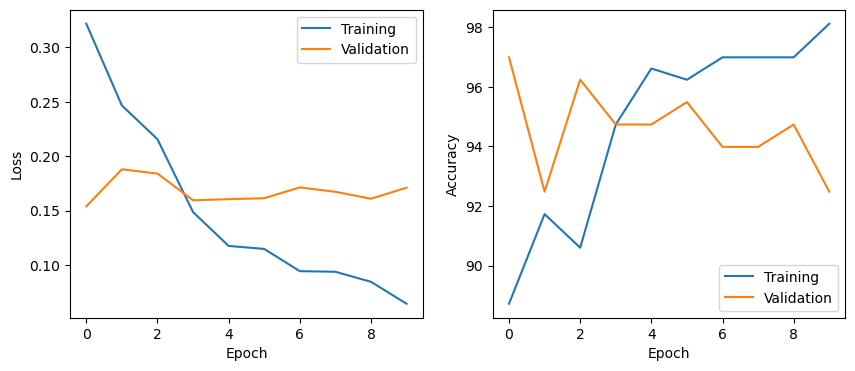

In [23]:
num_folds = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

#k-fold cross-validator
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


for fold, (train_idx, val_idx) in enumerate(skf.split(list(df.keys()), [v["target"] for v in df.values()])):
    print(f"Fold [{fold+1}/{num_folds}]")
    train_loss_list = []
    val_loss_list = []
    train_acc_list=[]
    val_acc_list=[]
    #VideoDataset and DataLoader objects
    train_dataset = VideoDataset({k: v for i, (k, v) in enumerate(df.items()) if i in train_idx})
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # validation set
    val_dataset = VideoDataset({k: v for i, (k, v) in enumerate(df.items()) if i in val_idx})
    val_loader = DataLoader(val_dataset, batch_size=32)

    #current fold
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_total = 0
        train_correct = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the training loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_loss = train_loss / train_total
        train_acc = 100.0 * train_correct / train_total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        model.eval()
        val_loss = 0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Update the validation loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss = val_loss / val_total
        val_acc = 100.0 * val_correct / val_total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
    
    
    # Plot for training and validation
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_list, label='Training')
    plt.plot(val_loss_list, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_acc_list, label='Training')
    plt.plot(val_acc_list, label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Validation loss increases while training accuracy and loss continue to be better. The model seems to have reached a plateau in terms of accuracy after a few epochs, as seen in the validation accuracy curve. The training loss and accuracy curves, on the other hand, continue to improve over time, suggesting that the model is overfitting the training data. It may be possible to improve the model's performance by reducing overfitting by adding regularization techniques such as dropout. we can experiment with different learning rates or other optimization parameters to see if they improve the model's performance.

In [19]:
class AudioModel(nn.Module):
    def __init__(self):
        super(AudioModel, self).__init__()
        self.fc1 = nn.Linear(313 * 40, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = x.view(-1, 313 * 40)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x


class VideoModel(nn.Module):
    def __init__(self):
        super(VideoModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 64 * 64, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 64 * 64)
        x = self.fc1(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x


class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        self.audio_model = AudioModel()
        self.video_model = VideoModel()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2, 1)
        
    def forward(self, audio_data, video_data):
        audio_data = audio_data.view(-1, 313 * 40)
        audio_output = self.audio_model(audio_data)
        video_output = self.video_model(video_data)
        combined_output = torch.cat((audio_output, video_output), dim=1)
        combined_output = self.dropout(combined_output)
        combined_output = self.fc(combined_output)
        return combined_output


In [25]:
audio_data_list = []
video_data_list = []
target_list = []
for key in df.keys():
    audio_data_list.append(df[key]['audio_data'])
    video_data_list.append(df[key]['video_data'])
    target_list.append(df[key]['target'])
#l2t
audio_data = torch.stack(audio_data_list)
video_data = torch.stack(video_data_list)
target = torch.tensor(target_list)

multimodal model combines an audio model and a video model. Both models output a single scalar value, which are then concatenated and passed through a fully connected layer with a dropout of 0.5 and a single output unit.

- The audio model is a simple feedforward neural network that takes in the audio data as a tensor of size (batch_size, 313, 40), flattens it to (batch_size, 313*40), applies a linear transformation, a batch normalization, a ReLU activation, and a dropout of 0.5. The output of the first layer is then passed through a second fully connected layer with a single output unit.

- The video model consists of two 2D convolutional layers with 16 and 32 output channels and then batch normalization ReLU activation, and max pooling. The output of the second convolutional layer is then flattened and passed through a fully connected layer with 256 output units and batch normalized, ReLU activation, and a dropout of 0.5. The output of the second fully connected layer is then passed through a third fully connected layer with a single output unit.

- The combined output of the audio and video models is concatenated and passed through a dropout layer and then through a fully connected layer with a single output unit. outputs of these models for a given input are concatenated using torch.cat, this output represents the final prediction of the model. This is a late fusion approach where the output of the audio and video models are concatenated and fed into a final fully connected layer for prediction. the fusion occurs after the individual modality models have already produced their outputs, during the forward pass,individual modality models first produce their outputs for the given input data and then these outputs are combined to produce the final output.

Fold 1
----------
Epoch 1: Train Loss = 0.6731, Val Loss = 0.6479, AUC Score = 0.5489
Epoch 2: Train Loss = 0.6440, Val Loss = 0.6510, AUC Score = 0.5552
Epoch 3: Train Loss = 0.6181, Val Loss = 0.6334, AUC Score = 0.5541
Epoch 4: Train Loss = 0.5945, Val Loss = 0.6026, AUC Score = 0.5663
Epoch 5: Train Loss = 0.5445, Val Loss = 0.5700, AUC Score = 0.5737
Epoch 6: Train Loss = 0.5151, Val Loss = 0.5365, AUC Score = 0.5619
Epoch 7: Train Loss = 0.4940, Val Loss = 0.5078, AUC Score = 0.5922
Epoch 8: Train Loss = 0.4815, Val Loss = 0.4925, AUC Score = 0.6100
Epoch 9: Train Loss = 0.4674, Val Loss = 0.4825, AUC Score = 0.6126
Epoch 10: Train Loss = 0.4726, Val Loss = 0.4890, AUC Score = 0.5807
Fold 2
----------
Epoch 1: Train Loss = 0.6551, Val Loss = 0.6308, AUC Score = 0.5956
Epoch 2: Train Loss = 0.5149, Val Loss = 0.5660, AUC Score = 0.5866
Epoch 3: Train Loss = 0.5105, Val Loss = 0.5091, AUC Score = 0.6154
Epoch 4: Train Loss = 0.4287, Val Loss = 0.5034, AUC Score = 0.6157
Epoch 5: Tr

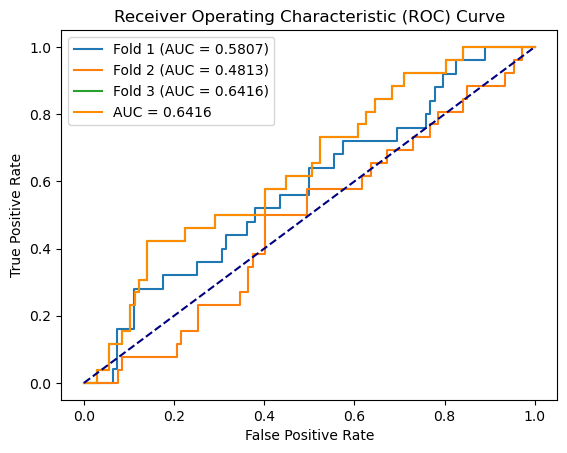

In [26]:
#folds
n_splits = 3

#k-fold cross-validator
kf = StratifiedKFold(n_splits=n_splits)

train_losses = []
val_losses = []
auc_scores = []

#ROC curve plot
fig, ax = plt.subplots()

for fold, (train_indices, val_indices) in enumerate(kf.split(list(df.keys()), [v["target"] for v in df.values()])):
    print(f'Fold {fold + 1}')
    print('-' * 10)

    
    audio_train, audio_val = audio_data[train_indices], audio_data[val_indices]
    video_train, video_val = video_data[train_indices], video_data[val_indices]
    target_train, target_val = target[train_indices], target[val_indices]

    #TensorDatasets & DataLoader
    train_dataset = TensorDataset(audio_train, video_train, target_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataset = TensorDataset(audio_val, video_val, target_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

  
    model = MultimodalModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(10):
        model.train()
        train_loss = 0
        for audio_batch, video_batch, target_batch in train_loader:
            optimizer.zero_grad()
            output = model(audio_batch, video_batch)
            loss = criterion(output, target_batch.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(audio_batch)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for audio_batch, video_batch, target_batch in val_loader:
                output = model(audio_batch, video_batch)
                loss = criterion(output, target_batch.float().unsqueeze(1))
                val_loss += loss.item() * len(audio_batch)
                y_true.extend(target_batch.tolist())
                y_pred.extend(torch.sigmoid(output).tolist())
            val_loss /= len(val_loader.dataset)
        auc_score = roc_auc_score(y_true, y_pred)

        print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, AUC Score = {auc_score:.4f}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        auc_scores.append(auc_score)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Fold {fold + 1} (AUC = {roc_auc:.4f})')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend()


print(f'Mean Train Loss = {np.mean(train_losses):.4f}')
print(f'Mean Val Loss = {np.mean(val_losses):.4f}')
print(f'Mean AUC Score = {np.mean(auc_scores):.4f}')

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()

Here, we create TensorDatasets and DataLoaders for the training and validation set and train the MultimodalModel using binary cross-entropy loss BCEWithLogitsLoss that measures the difference between the predicted probabilities and the true binary labels to minimize this difference during training. Adam optimizer which adjusts the learning rate based on the gradients of the loss function with respect to the model parameters

AUC roc score not very great to be dependent on the model probably audio model was not properly processed and this may cause problem to interpret video and audio for the model. Each modality should capture each frame and should correspond to same time frame.

In [52]:
dataset2 = TensorDataset(audio_data, video_data, target)
data_loader2 = DataLoader(dataset2, batch_size=16, shuffle=True)


- mcnemar test using:
    - model1 = SimpleCNN()
    - model2 = MultimodalModel()

In [59]:
#macnemar test to compare performance
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

dataset = VideoDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#models
model1 = SimpleCNN()
model2 = MultimodalModel()

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
criterion2 = nn.BCEWithLogitsLoss()


#epochs
num_epochs = 10

for epoch in range(num_epochs):
    model1.train()
    for inputs, labels in dataloader:
        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

#Evaluate model 1
model1.eval()
y_true = []
y_pred1 = []
with torch.no_grad():
    for inputs, labels in dataloader:
        outputs = model1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred1.extend(predicted.cpu().numpy())
accuracy1 = accuracy_score(y_true, y_pred1)
print("Accuracy of model 1:", accuracy1)

#Train model 2
for epoch in range(num_epochs):
    model2.train()
    for audio_batch, video_batch, target_batch in data_loader2:
        optimizer2.zero_grad()
        outputs = model2(audio_batch, video_batch)
        loss = criterion2(outputs.squeeze(), target_batch.float())
        loss.backward()
        optimizer2.step()

#Evaluate model 2
model2.eval()
y_true2 = []
y_pred2 = []
with torch.no_grad():
    for audio_batch, video_batch, target_batch in data_loader2:
        outputs = model2(audio_batch, video_batch)
        y_true2.extend(target_batch.cpu().numpy())
        y_pred2.extend(np.where(outputs.sigmoid().cpu().numpy().squeeze() > 0.5, 1, 0))
accuracy2 = accuracy_score(y_true2, y_pred2)
print("Accuracy of model 2:", accuracy2)

#contingency table
b = 0
c = 0
for i in range(len(y_true)):
    if y_pred1[i] == y_true[i] and y_pred2[i] != y_true[i]:
        b += 1
    elif y_pred2[i] == y_true[i] and y_pred1[i] != y_true[i]:
        c += 1

#McNemar test statistic
statistic = ((b - c) ** 2) / (b + c)

print("McNemar test statistic:", statistic)

Accuracy of model 1: 0.8646616541353384
Accuracy of model 2: 0.8822055137844611
McNemar test statistic: 35.526315789473685


In [71]:
from scipy.stats import chi2

# Calculate p-value
p_value = 1 - chi2.cdf(statistic, 1)

print("p-value:", float('{:.10f}'.format(p_value)))

p-value: 2.5e-09


- Both model do not have similar performance as p-value<0.05. Multimodal perform better for out data.

# shared latent space among all input modalities

The audio and video modalities are processed independently by their  models, which extract features from the audio and video inputs and map them to a shared latent space of size shared_latent_dim. The outputs of the two models are then concatenated and fed into a classification layer (self.fc) to obtain the final prediction. The model is able to capture common information using sharing the latent space between the audio and video modalities, which can improve its ability to make accurate predictions.

In [47]:
class AudioModel1(nn.Module):
    def __init__(self, shared_latent_dim):
        super(AudioModel1, self).__init__()
        self.fc1 = nn.Linear(313 * 40, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.shared_fc = nn.Linear(256, shared_latent_dim)  # shared latent space layer
        
    def forward(self, x):
        x = x.view(-1, 313 * 40)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        shared_output = self.shared_fc(x)  # shared latent space output
        return shared_output


class VideoModel1(nn.Module):
    def __init__(self, shared_latent_dim):
        super(VideoModel1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 64 * 64, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.shared_fc = nn.Linear(256, shared_latent_dim)  # shared latent space layer
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 64 * 64)
        x = self.fc1(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        shared_output = self.shared_fc(x)  # shared latent space output
        return shared_output


class MultimodalModel1(nn.Module):
    def __init__(self, shared_latent_dim):
        super(MultimodalModel1, self).__init__()
        self.audio_model = AudioModel1(shared_latent_dim)
        self.video_model = VideoModel1(shared_latent_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(shared_latent_dim * 2, 1)  # classification layer
        
    def forward(self, audio_data, video_data):
        audio_output = self.audio_model(audio_data)
        video_output = self.video_model(video_data)
        combined_output = torch.cat((audio_output, video_output), dim=1)
        combined_output = self.dropout(combined_output)
        combined_output = self.fc(combined_output)
        return combined_output



In [49]:
# Define the hyperparameters
shared_latent_dim = 128
batch_size = 16
learning_rate = 0.001
num_epochs = 10

dataset = TensorDataset(audio_data, video_data, target)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Instantiate the model and optimizer
model = MultimodalModel1(shared_latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Move the model and data to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
audio_data = audio_data.to(device)
video_data = video_data.to(device)
target = target.to(device)

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for audio_batch, video_batch, target_batch in train_loader:
        optimizer.zero_grad()
        audio_batch = audio_batch.to(device)
        video_batch = video_batch.to(device)
        target_batch = target_batch.to(device)
        output = model(audio_batch, video_batch)
        loss = criterion(output.squeeze(), target_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * audio_batch.size(0)
    train_loss /= len(train_dataset)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for audio_batch, video_batch, target_batch in val_loader:
            audio_batch = audio_batch.to(device)
            video_batch = video_batch.to(device)
            target_batch = target_batch.to(device)
            output = model(audio_batch, video_batch)
            loss = criterion(output.squeeze(), target_batch.float())
            val_loss += loss.item() * audio_batch.size(0)
        val_loss /= len(val_dataset)
        
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 1/10, Train Loss: 0.6111, Val Loss: 0.3942
Epoch 2/10, Train Loss: 0.4733, Val Loss: 0.3632
Epoch 3/10, Train Loss: 0.4470, Val Loss: 0.3596
Epoch 4/10, Train Loss: 0.3906, Val Loss: 0.3797
Epoch 5/10, Train Loss: 0.3442, Val Loss: 0.3435
Epoch 6/10, Train Loss: 0.3174, Val Loss: 0.4255
Epoch 7/10, Train Loss: 0.2954, Val Loss: 0.4611
Epoch 8/10, Train Loss: 0.2616, Val Loss: 0.4330
Epoch 9/10, Train Loss: 0.2523, Val Loss: 0.5891
Epoch 10/10, Train Loss: 0.2307, Val Loss: 0.5451


Epoch 1/10, Train Loss: 0.5106, Val Loss: 0.6617
Epoch 2/10, Train Loss: 0.4220, Val Loss: 0.5943
Epoch 3/10, Train Loss: 0.3697, Val Loss: 0.6102
Epoch 4/10, Train Loss: 0.3422, Val Loss: 0.6543
Epoch 5/10, Train Loss: 0.3072, Val Loss: 0.8746
Epoch 6/10, Train Loss: 0.2606, Val Loss: 0.8592
Epoch 7/10, Train Loss: 0.2660, Val Loss: 0.9187
Epoch 8/10, Train Loss: 0.2093, Val Loss: 0.9588
Epoch 9/10, Train Loss: 0.2452, Val Loss: 0.9206
Epoch 10/10, Train Loss: 0.1931, Val Loss: 0.9442


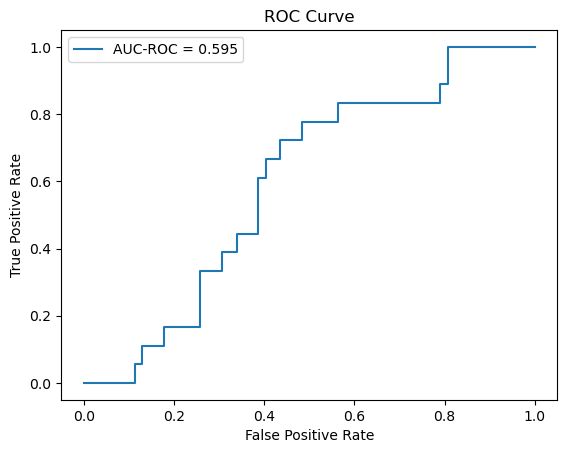

In [51]:
#hyperparameters
shared_latent_dim = 128
batch_size = 16
learning_rate = 0.001
num_epochs = 10

dataset = TensorDataset(audio_data, video_data, target)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
model = MultimodalModel1(shared_latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
audio_data = audio_data.to(device)
video_data = video_data.to(device)
target = target.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for audio_batch, video_batch, target_batch in train_loader:
        optimizer.zero_grad()
        audio_batch = audio_batch.to(device)
        video_batch = video_batch.to(device)
        target_batch = target_batch.to(device)
        output = model(audio_batch, video_batch)
        loss = criterion(output.squeeze(), target_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * audio_batch.size(0)
    train_loss /= len(train_dataset)
    
    model.eval()
    y_true = []
    y_pred = []
    val_loss = 0
    with torch.no_grad():
        for audio_batch, video_batch, target_batch in val_loader:
            audio_batch = audio_batch.to(device)
            video_batch = video_batch.to(device)
            target_batch = target_batch.to(device)
            output = model(audio_batch, video_batch)
            y_true.extend(target_batch.cpu().numpy())
            y_pred.extend(output.sigmoid().cpu().numpy().squeeze())
            loss = criterion(output.squeeze(), target_batch.float())
            val_loss += loss.item() * audio_batch.size(0)
        val_loss /= len(val_dataset)
        
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
auc_roc = roc_auc_score(y_true, y_pred)
#ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
    


validation loss appear to be more than our accuracy. such problem should be handled at lower level while data processing. This would change any possible issue that may arise at later stage of developement or maybe they are calculation mistake.

- Assignment: Multi-Modal Detecting DeepFake Videos


- Dataset: https://www.kaggle.com/competitions/deepfake-detection-challenge/data
        - 322 FAKE and 77 REAL Videos
        - Size: 4.98 GB

- Model:
        - 1. SimpleCNN(): Train Loss: 0.0545, Train Accuracy: 97.74%, Val Loss: 0.0918, Val Accuracy: 97.74%, Val F1: 0.9776, Val AUC: 0.9714
        - 2. SimpleRNN(): Accuracy: 75.00%
        - 3. MultimodalModel(): Train Loss = 0.4071, Val Loss = 0.4847, AUC Score = 0.6416, Mean Train Loss = 0.5155, Mean Val Loss = 0.5343, Mean AUC Score = 0.5967
        - 4. MultimodalModel1(): AUC-ROC=0.595, Train Loss: 0.1931, Val Loss: 0.9442

- Dataset Preprocessing:
        - 1. StratifiedKFold to stratify across all fold.
        - 2.. Video and audio is normalized and scaled.
- Metrics:
        - 1. Accuracy
        - 2. F1 score
        - 3. AUC-ROC
- mcnemar test:
        - p-value: 2.5e-09
        - MultimodalModel() perform better.

Knowledge:
- Techniques such as transfer learning to leverage pre-trained models and improve the accuracy of model.
- Process audio and video frame to match sequence.
- input shape should be properly monitored or at the end of assignment we might realise that some data techniques needs to be monitored.

- Reference:
    - Dr. Eric Larson
    - https://github.com/eclarson/MachineLearningNotebooks/blob/master/13.%20RNN%20Basics.ipynb
    - https://github.com/8000net/LectureNotesMaster

                                            Thank you Professor